# STOR 566, Homework 4
### Instructor: Yao Li
### Keywords: VAE, GAN
### Due date: Oct 16, 11:55pm
### **Submission Instruction**

- Please download this script and use it to answer the questions in the homework. 
- For submission, please include your code, code output and answers in the script and submit the ipynb file on sakai.
- Please don't modify existing cells. But you can add cells between the exercise statements.
- To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language. For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

### **References:**

- You can follow the setup instructions at [here](https://pytorch.org/get-started/locally/).
- A useful tutorial on learning pytorch by examples at [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).
- Check Pytorch optimization methods at [here](https://pytorch.org/docs/stable/optim.html).
- Check Pytorch DC-GAN tutorial at [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).


### **Evaluation Metrics of Generator:**

- [Fréchet Inception Distance](https://arxiv.org/pdf/1706.08500.pdf): compares the distribution of generated images with the distribution of a set of real images

    - Code Reference: https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/

- [Inception Score](https://arxiv.org/abs/1606.03498): measures two things simultaneously

    - The images have variety (e.g. each image is a different breed of dog)
    - Each image distinctly looks like something (e.g. one image is clearly a Poodle, the next a great example of a French Bulldog)
    - Code Reference: https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/

## Problem 1 (40 points)

In this problem you will practice implementing Variational Auto-Encoder (VAE) on MNIST data set.

**Data.** You will use MNIST digit classification dataset. Pytorch/torchvision has provide a useful dataloader to automatically download and load the data into batches. Code of the data loader has been provided in the template. Please don't modify the data loading part.

In [ ]:
'''
# You need package pytorch-ignite for the last question
# To avoid loading it every time, you can install pytorch-ignite to a path on google drive
import os
from google.colab import drive
drive.mount('/content/drive')
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'
!pip install --target=$pkg_path pytorch-ignite

# Append the path to the sys path to load the pkg without re-installation
import sys
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'
sys.path.append(pkg_path)
import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.metrics import FID, InceptionScore
'''

"\n# You need package pytorch-ignite for the last question\n# To avoid loading it every time, you can install pytorch-ignite to a path on google drive\nimport os\nfrom google.colab import drive\ndrive.mount('/content/drive')\npkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'\n!pip install --target=$pkg_path pytorch-ignite\n\n# Append the path to the sys path to load the pkg without re-installation\nimport sys\npkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'\nsys.path.append(pkg_path)\nimport ignite.distributed as idist\nfrom ignite.engine import Engine, Events\nfrom ignite.metrics import FID, InceptionScore\n"

In [ ]:
!pip install --target=$pkg_path pytorch-ignite
from ignite.engine import Engine, Events
from ignite.metrics import FID, InceptionScore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 264 kB 32.4 MB/s 


In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch.utils.data as td
import random, time
import matplotlib.pyplot as plt
import torchvision
import PIL.Image as Image
import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.metrics import FID, InceptionScore
from torchvision import datasets, transforms
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [2]:
## Data loading code chunk, please don't modify it. 
## However, you can adjust the batch size if you want to.
batch_size = 128

def mnist_loaders(batch_size): 
    data_dir = './data'
    train_data = datasets.MNIST(data_dir, train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                      ]))
    # Once you have downloaded the data by setting download=True, you can
    # change download=True to download=False
    test_data = datasets.MNIST(data_dir, train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                      ]))
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, 
      shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size, 
      shuffle=False)
    return train_loader, test_loader

train_mnist_loader, test_mnist_loader = mnist_loaders(batch_size)

In [3]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
model = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
model.to(device)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [4]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [5]:
vae_avg_loss=[]

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_mnist_loader):
        optimizer.zero_grad()
        data = data.cuda()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_mnist_loader.dataset),
                100. * batch_idx / len(train_mnist_loader), loss.item() / len(data)))
            
    vae_avg_loss.append(train_loss / len(train_mnist_loader.dataset))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_mnist_loader.dataset)))

for epoch in range(0,10):
  train(epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/60000 (0%)]	Loss: 548.241272
Train Epoch: 0 [12800/60000 (21%)]	Loss: -15913.771484
Train Epoch: 0 [25600/60000 (43%)]	Loss: -19604.398438
Train Epoch: 0 [38400/60000 (64%)]	Loss: -20990.849609
Train Epoch: 0 [51200/60000 (85%)]	Loss: -23318.185547
====> Epoch: 0 Average loss: -18645.0834
Train Epoch: 1 [0/60000 (0%)]	Loss: -22511.835938
Train Epoch: 1 [12800/60000 (21%)]	Loss: -22922.375000
Train Epoch: 1 [25600/60000 (43%)]	Loss: -24810.580078
Train Epoch: 1 [38400/60000 (64%)]	Loss: -24359.910156
Train Epoch: 1 [51200/60000 (85%)]	Loss: -25254.339844
====> Epoch: 1 Average loss: -23971.1174
Train Epoch: 2 [0/60000 (0%)]	Loss: -25037.937500
Train Epoch: 2 [12800/60000 (21%)]	Loss: -25612.308594
Train Epoch: 2 [25600/60000 (43%)]	Loss: -25952.316406
Train Epoch: 2 [38400/60000 (64%)]	Loss: -24807.843750
Train Epoch: 2 [51200/60000 (85%)]	Loss: -25235.535156
====> Epoch: 2 Average loss: -25419.7638
Train Epoch: 3 [0/60000 (0%)]	Loss: -25180.427734
Train Epoch: 3 [1280

### **Problem Description.** Implement **VAE** with Pytorch on MNIST.

### (a) (5 points) Print the model architecture.

In [6]:
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)


### (b) (5 points) Report the hyper-parameters (number of epochs, learning rate, momentum, weight_decay etc).

Answer:<br>
Number of epochs = 10, <br>
Learning rate = 1e-3, <br>
betas = (0.9, 0.999), <br>
eps = 1e-08, <br>
batch_size = 128,<br>
weight_decay = 0, <br>
amsgrad = False, <br>
foreach = None, <br>
maximize = False, <br>
capturable = False<br>

### (c) (20 points) Report the **VAE Loss** after every training epoch by generating Loss vs. Epoch plot. Please report at least **10** epochs.

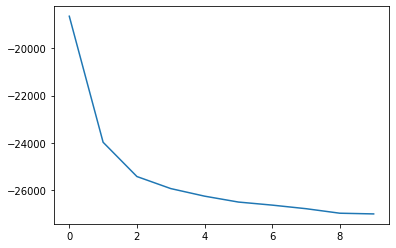

In [7]:
import matplotlib.pyplot as plt
plt.plot(vae_avg_loss)

### (d) (10 points) Please apply the trained VAE model on a batch (128) of test samples and visualize both the test samples and reconstructed samples. Do the reconstructed samples look good?

Here is the test samples.

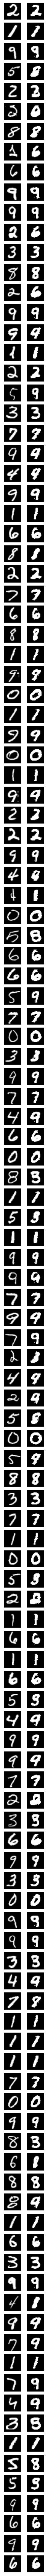

In [8]:

model.eval()
with torch.no_grad():

  for idx, data in enumerate(train_mnist_loader, 0):
    imgs, _ = data
    imgs = imgs.to(device)
    plt.figure(figsize=(2, 128), dpi=80)
    for i in range(batch_size):

      img1 = imgs[i].reshape((1,28,28))
      img = np.transpose(img1.cpu().numpy(), [1,2,0])
      out, mu, logVAR = model(imgs)
      
      out1 = out[i].reshape((1,28,28))
      outimg = np.transpose(out1.cpu().numpy(), [1,2,0])

      plt.subplot(128, 2, 2*i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(np.squeeze(img), cmap="gray")

      plt.subplot(128, 2, 2*i + 2)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(np.squeeze(outimg), cmap="gray")


    break
  

Answer: We can see that the reconstructed samples mainly look good, but there are some samples are unclear that we cannot figure out what it is. Besides, there is a little mistakes happening here.

## Problem 2 (60 points)

In this problem you will practice implementing DC-GAN on CIFAR10 data set.

**Data.** You will use CIFAR10 classification dataset (10 classes). Pytorch/torchvision has provide a useful dataloader to automatically download and load the data into batches. Code of the data loader has been provided in the template. Please don't modify the data loading part.

In [19]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [5]:
## Data loading code chunk, please don't modify it. 
## However, you can adjust the batch size if you want to.
batch_size_cifar = 64

def cifar_loaders(batch_size, shuffle_test=False): 
    data_dir = './data'
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.225, 0.225, 0.225])
    train = datasets.CIFAR10(data_dir, train=True, download=True, 
        transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]))
    # Once you have downloaded the data by setting download=True, you can
    # change download=True to download=False
    test = datasets.CIFAR10(data_dir, train=False, 
        transform=transforms.Compose([transforms.ToTensor(), normalize]))
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
        shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
        shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader

train_cifar_loader, test_cifar_loader = cifar_loaders(batch_size_cifar)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
print(len(train_cifar_loader))
print(len(test_cifar_loader))

782
157


In [22]:
# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [23]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [24]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 2, 4, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [25]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(2, 2), stride=(4, 4), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [26]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 4, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

        

In [27]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(2, 2), stride=(4, 4), bias=False)
    (12): Sigmoid()
  )
)


### **Problem Description.** Implement **DC-GAN** with Pytorch on CIFAR10.

### (a) (5 points) Print the model architecture (discriminator and generator).

In [28]:
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(2, 2), stride=(4, 4), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### (b) (20 points) Report the **Generator Loss** and **Discriminator Loss** after every training epoch by generating Loss vs. Epoch plot. Please report at least **10** epochs and include two curves in the same plot with legend.

In [29]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [30]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    g_loss = 0
    d_loss = 0
    # For each batch in the dataloader
    for i, data in enumerate(train_cifar_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_cifar_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        d_loss += errD.item()
        g_loss += errG.item()

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_cifar_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    G_losses.append(errG.item()/iters)
    D_losses.append(errD.item()/iters)
    #print("Epoch = [{}/{}], Loss_D = {}, Loss_G = {}".format(epoch + 1, num_epochs, d_loss/iters, g_loss/iters))

Starting Training Loop...
[0/10][0/782]	Loss_D: 1.3998	Loss_G: 3.0479	D(x): 0.4774	D(G(z)): 0.4561 / 0.0526
[0/10][50/782]	Loss_D: 0.6225	Loss_G: 9.1023	D(x): 0.8967	D(G(z)): 0.3781 / 0.0001
[0/10][100/782]	Loss_D: 0.5100	Loss_G: 4.2924	D(x): 0.8602	D(G(z)): 0.2755 / 0.0166
[0/10][150/782]	Loss_D: 0.4282	Loss_G: 3.0797	D(x): 0.7358	D(G(z)): 0.0461 / 0.0587
[0/10][200/782]	Loss_D: 0.1465	Loss_G: 4.6269	D(x): 0.9104	D(G(z)): 0.0308 / 0.0159
[0/10][250/782]	Loss_D: 0.6411	Loss_G: 4.7297	D(x): 0.7282	D(G(z)): 0.2003 / 0.0113
[0/10][300/782]	Loss_D: 0.3853	Loss_G: 6.0411	D(x): 0.8808	D(G(z)): 0.1997 / 0.0044
[0/10][350/782]	Loss_D: 0.2403	Loss_G: 4.6028	D(x): 0.8638	D(G(z)): 0.0701 / 0.0121
[0/10][400/782]	Loss_D: 0.3023	Loss_G: 5.9273	D(x): 0.9168	D(G(z)): 0.1820 / 0.0032
[0/10][450/782]	Loss_D: 0.2037	Loss_G: 4.9673	D(x): 0.9090	D(G(z)): 0.0845 / 0.0090
[0/10][500/782]	Loss_D: 0.0522	Loss_G: 5.7634	D(x): 0.9543	D(G(z)): 0.0026 / 0.0162
[0/10][550/782]	Loss_D: 0.0934	Loss_G: 5.6590	D(x): 0

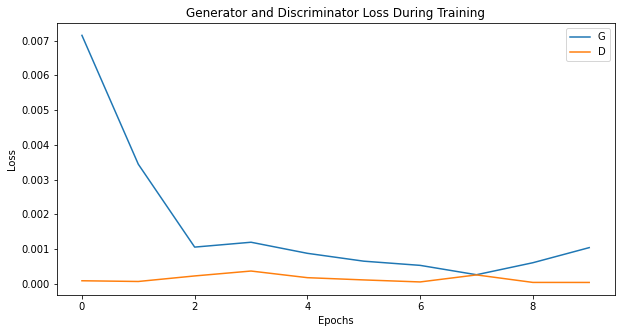

In [31]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


### (c) (10 points) Please use the trained DC-GAN model to generate a batch (64) new samples and visualize the generated samples. How do they look? Do they look like real samples?

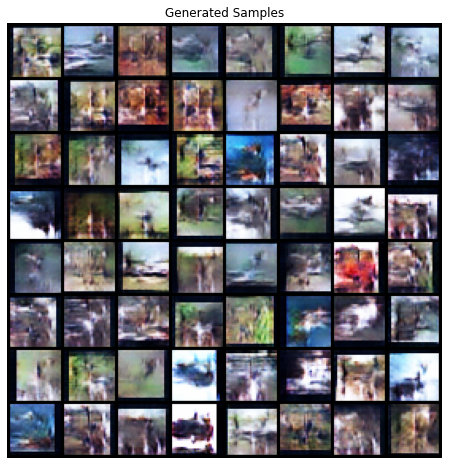

In [32]:
import torchvision
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Samples")
plt.imshow(np.transpose(torchvision.utils.make_grid(fake.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


From the generated samples above, I think they are pretty good. Theylook like real images. 

### (d) (25 points) Please evaluate the trained DC-GAN model using Fréchet Inception Distance (FID) and Inception Score (IS) on the testset. 

In [33]:
!pip install --target=$pkg_path pytorch-ignite
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 264 kB 29.2 MB/s 


In [39]:
netG = idist.auto_model(Generator(ngpu)).to(device)
netD = idist.auto_model(Discriminator(ngpu)).to(device)

optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
)


In [40]:
real_label = 1
fake_label = 0
batch_size = 64


def training_step(engine, data):
    # Set the models for training
    netG.train()
    netD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = netD(real).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output3, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

In [41]:
trainer = Engine(training_step)

In [42]:
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [43]:
@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)

In [44]:
G_losses = []
D_losses = []


@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

In [45]:
img_list = []


@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)

In [46]:
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore

In [47]:
fid_metric = FID(device=idist.device())
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

In [48]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(len(batch[0]), nz, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

In [49]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [50]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_cifar_loader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

In [51]:
from ignite.metrics import RunningAverage


RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [52]:
from ignite.contrib.handlers import ProgressBar


ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

In [55]:
def training(*args):
  trainer.run(train_cifar_loader, max_epochs=5)

In [60]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

2022-10-17 20:49:39,287 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2022-10-17 20:49:39,289 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7fe66ee9c7a0>' in 1 processes


[1/782]   0%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Epoch [1/5] Metric Scores
*   FID : 0.038545
*    IS : 1.469623


[1/782]   0%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Epoch [2/5] Metric Scores
*   FID : 0.062298
*    IS : 1.653321


[1/782]   0%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Epoch [3/5] Metric Scores
*   FID : 0.038322
*    IS : 1.486923


[1/782]   0%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Epoch [4/5] Metric Scores
*   FID : 0.047740
*    IS : 1.534771


[1/782]   0%|           [00:00<?]

[1/157]   1%|           [00:00<?]

2022-10-17 21:09:04,078 ignite.distributed.launcher.Parallel INFO: End of run
2022-10-17 21:09:04,085 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


Epoch [5/5] Metric Scores
*   FID : 0.045781
*    IS : 1.549168


In [61]:
print(fid_values)
print(is_values)

[0.015005420873093644, 0.03673476263784628, 0.041640185395476995, 0.041491627737263545, 0.038544865150691235, 0.06229780832640258, 0.038322266074438435, 0.04774047921064825, 0.045781061519092336]
[1.3476656468216532, 1.449562226378356, 1.4850610545624174, 1.5834602915229756, 1.469622814362947, 1.653321289128274, 1.4869233301605944, 1.5347713536460246, 1.549168210672814]


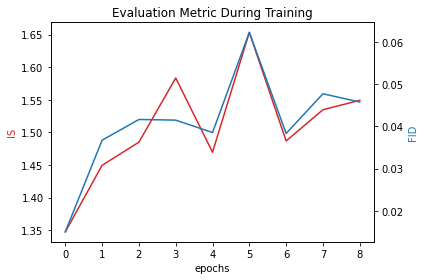

In [62]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()